# Using NP4VTT: Artificial Neural Network

In this notebook, we show how to use an Artificial Neural Network (ANN) to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the ANN, and Pandas to load the dataset:

In [1]:
import pandas as pd

from py_np4vtt.data_format import StudyVar
from py_np4vtt.model_ann import ModelANN, ConfigANN
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [3]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL` and `CostR`: Travel cost of alternatives 1 and 2, respectively.
* `TimeL` and `TimeR`: Travel time of alternatives 1 and 2, respectively.

NP4VTT detects automatically the _slow-cheap_ and _fast-expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [3]:
columnarrays = {
    StudyVar.Id: 'RespID',
    StudyVar.ChosenAlt: 'Chosen',
    StudyVar.Cost1: 'CostL',
    StudyVar.Cost2: 'CostR',
    StudyVar.Time1: 'TimeL',
    StudyVar.Time2: 'TimeR',
}

And we create the required arrays:

In [4]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [5]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 0.5370130170428368
Minimum of BVTT: 0.1
Maximum of BVTT: 17.03448275862069


## Step 3: Configure an ANN

The ANN requires the following parameters from the user:

* `hiddenLayerNodes`: A list of length equal to the number of hidden layers. Each element is the number of hidden nodes of each hidden layer.
* `trainingRepeats`: Number of training repeats
* `shufflesPerRepeat`: Number of shuffles of the data (for randomisation of choice situation and data expansion)

Additionally, the user can configure the following options:
* `seed`: Random seed for shuffling and simulation.

The function `ConfigANN` takes the configuration parameters of the ANN and creates an object that is used by the optimisation routine:

In [6]:
config = ConfigANN(hiddenLayerNodes=[10, 10], trainingRepeats= 20, shufflesPerRepeat= 50, seed= None)

Now, we create the ANN object that contains the configuration parameters and the data arrays. Then, we initialise the arguments:

In [7]:
ann = ModelANN(config, model_arrays)
initialArgs = ann.setupInitialArgs()

## Step 4: Train an ANN

Once the ANN is initialised, the `run` method starts the optimisation process:

In [8]:
ll, r2, clf, vtt = ann.run(initialArgs)

The training process returns the following information:

* `ll:` A list with the log-likelihood of each repetition
* `r2:` A list with the Rho-squared of each repetition
* `clf:` A list with the `sklearn` trained model objects.
* `vtt:` A list with the estimated VTT per repetition

The following lines present the estimated results:

In [9]:
import numpy as np

# Create dataframe
results = pd.DataFrame(np.c_[ll,r2],columns=['Log-likelihood','Rho-squared'],index=['Rep. ' + str(i+1) for i in range(len(ll))])

print('Training results:')
print(results)

Training results:
         Log-likelihood  Rho-squared
Rep. 1   -106135.925111     0.474891
Rep. 2   -105513.743198     0.477969
Rep. 3   -106271.281005     0.474221
Rep. 4   -106811.865141     0.471547
Rep. 5   -106436.854091     0.473402
Rep. 6   -106800.409842     0.471603
Rep. 7   -108302.789161     0.464170
Rep. 8   -106227.248356     0.474439
Rep. 9   -106141.891893     0.474862
Rep. 10  -107215.402240     0.469550
Rep. 11  -106355.925049     0.473803
Rep. 12  -105921.458544     0.475952
Rep. 13  -107511.187948     0.468087
Rep. 14  -105957.332860     0.475775
Rep. 15  -106315.429796     0.474003
Rep. 16  -106456.700422     0.473304
Rep. 17  -105620.049301     0.477443
Rep. 18  -107206.335022     0.469595
Rep. 19  -106435.058213     0.473411
Rep. 20  -106252.897926     0.474312


## Step 5: Do plots

We create two plots of the VTT distribution:
* Histogram
* Empirical CDF

We use matplotlib for this:

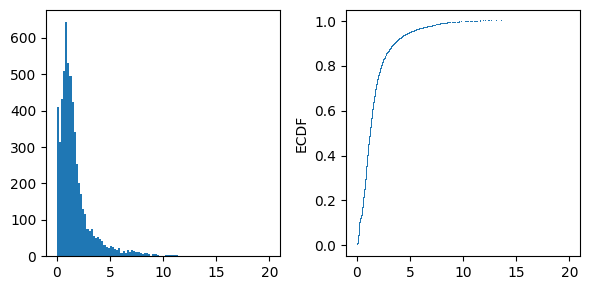

In [11]:
vtt_mean = vtt.mean(axis=0)

import matplotlib.pyplot as plt
from mlxtend.plotting import ecdf
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(6,3), dpi=100)

# Histogram
ax1.hist(vtt_mean,bins=100,range=(0,20))

# ECDF
ax2 = ecdf(vtt_mean,ecdf_marker=',')

plt.tight_layout()